<a href="https://colab.research.google.com/github/alanflorendo/building_micrograd/blob/main/01_migrograd_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np

In [149]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0 # initially assume there is no effect on the loss function
    self._backward = lambda: None # base case: this does nothing (eg, for a leaf node)
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other): # a - b
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other): # x ** k
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self,), f"**{other}")

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    """e to the power of x"""
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # dy/e^x is (famously) simply e^x
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [5]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    
    # for any value in the graph, create a rectangle ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [28]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
# o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label='o'


In [30]:
o.backward()

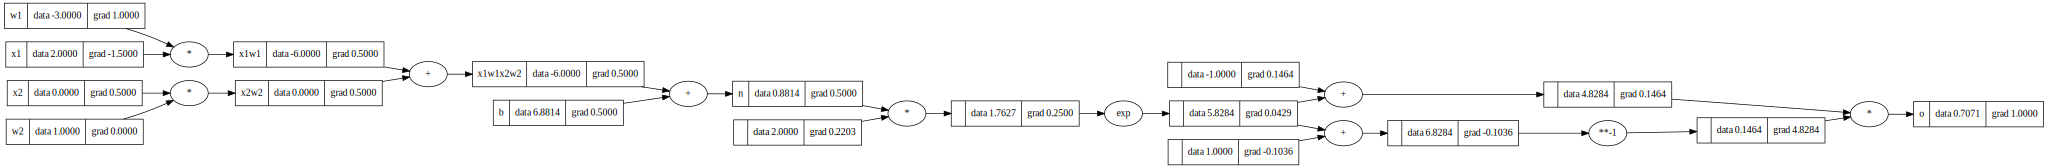

In [31]:
draw_dot(o)

In [32]:
import torch

In [34]:
x1 = torch.Tensor([2.0]).double();                         x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                         x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                        w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                         w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();         b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [109]:
import random

class Neuron:
  def __init__(self, nin):
    # nin = number of inputs to a neuron
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]    

  
class MLP: # MultiLayer Perceptron
  def __init__(self, nin, nouts):
    # nouts is a list of the sizes of each layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [112]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) 
n(x)

Value(data=0.417430590106069)

In [ ]:
draw_dot(n(x))

In [150]:
xs = [
    [2.0, 3.0, -1.0], # desire 1.0 when fed these three examples
    [3.0, -1.0, 0.5], # desire -1.0
    [0.5, 1.0, 1.0],  # desire -1.0
    [1.0, 1.0, -1.0], # desire 1.0
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.18130571105647156),
 Value(data=-0.1846505907673353),
 Value(data=-0.25382036290617827),
 Value(data=0.3567165223887841)]

In [ ]:
# LOSS

"""
Value(data=0.5310120727506463),      ==> should be 1.0
 Value(data=-0.25815736605298417),   ==> should be -1.0
 Value(data=0.42871258953854874),    ==> should be -1.0
 Value(data=0.5548864532459099)      ==> should be 1.0
"""

In [95]:
# ygt = Y-ground-truth???
individual_losses = [(yout - ygt)**2 for ygt, yout, in zip(ys, ypred)]
individual_losses

[Value(data=0.21994967590564504),
 Value(data=0.5503304935414463),
 Value(data=2.041219663505945),
 Value(data=0.19812606950400555)]

In [97]:
# Why do I get an error when I try this???
# ah well, see next cell

loss = sum(individual_losses)

TypeError: ignored

In [102]:
loss = individual_losses[0] + individual_losses[1] + individual_losses[2] + individual_losses[3]
loss

Value(data=3.009625902457042)

In [116]:
loss.backward()

In [107]:
n.layers[0].neurons[0].w[0].grad # this neuron is somewhat positive, so decreasing this weight somewhat should help

0.32849823354852015

In [117]:
n.parameters()

[Value(data=0.0730765816731882),
 Value(data=0.08152796077920521),
 Value(data=0.28183141238352927),
 Value(data=0.610503280607251),
 Value(data=-0.951045900078404),
 Value(data=0.060435700178231855),
 Value(data=-0.8555439460361101),
 Value(data=0.7434858148242538),
 Value(data=0.8238108922217553),
 Value(data=-0.6207200138181648),
 Value(data=-0.43299525169792963),
 Value(data=-0.07636796951225189),
 Value(data=-0.7078256857330616),
 Value(data=-0.05796044705818115),
 Value(data=-0.4768332567725797),
 Value(data=-0.01543082713402022),
 Value(data=0.8972674658128084),
 Value(data=0.9044236910757657),
 Value(data=-0.24541062539466552),
 Value(data=0.9568757770792469),
 Value(data=0.8049315041903711),
 Value(data=-0.18228477539821797),
 Value(data=-0.5188763757524579),
 Value(data=-0.9848352053582943),
 Value(data=-0.38941440353744894),
 Value(data=-0.4888485986811866),
 Value(data=0.7231433158590181),
 Value(data=0.9461096774071396),
 Value(data=0.08217605026338592),
 Value(data=0.8350

In [137]:
# let's try to optimize
for p in n.parameters():
  p.data += -0.01 * p.grad


In [138]:
ypred = [n(x) for x in xs]
individual_losses = [(yout - ygt)**2 for ygt, yout, in zip(ys, ypred)]
loss = individual_losses[0] + individual_losses[1] + individual_losses[2] + individual_losses[3]
loss

Value(data=3.0308755254917386)

In [139]:
# iterate over the two steps above
# loss = Value(data=5.434210940349174)
# loss = Value(data=5.434210940349174)
# loss = Value(data=4.6967107317207315)
# loss = Value(data=4.343179819706409)
# loss = Value(data=3.7188337650129175)
# loss = Value(data=3.2672941309168038)
# loss = Value(data=3.1215338972012923)


In [ ]:
# you have to find the right step size
# too low: you'll take forever to converge
# too high: you'll destabilize and overshoot --> you can only find out about LOCAL minimums, so we can't assume the grads will stay the same over a larger step

In [153]:
for k in range(10):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout, in zip(ys, ypred)) # BUT I CAN'T SUM

  # backward pass
  for p in n.parameters():
    p.grad = 0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.02908061691230791
1 0.027487172084796004
2 0.026053199292431058
3 0.02475623432530628
4 0.02357781150553871
5 0.022502616002399868
6 0.02151784237066703
7 0.020612703186864118
8 0.019778048434471108
9 0.019006067634018867


In [144]:
Value(3) + Value(5)

Value(data=8)

In [143]:
sum([Value(3), Value(5)])

TypeError: ignored